### Dependencies

In [1]:
# CS194-26 (CS294-26): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.io as skio
from skimage import img_as_float
from skimage.transform import rescale
from scipy.ndimage import shift
from skimage import feature

In [2]:
def normalized_cross_correlation(arr1: np.ndarray, arr2: np.ndarray) -> float:
    arr1_norm = (arr1 - np.mean(arr1)) / np.std(arr1)
    arr2_norm = (arr2 - np.mean(arr2)) / np.std(arr2)
    ncc = np.sum(arr1_norm * arr2_norm)

    return ncc

def align(im1: np.ndarray, im2: np.ndarray, max_shift: int = 15):
    best_dx, best_dy = 0, 0
    max_ncc = -float('inf')

    for dx in range(-max_shift, max_shift + 1):
        for dy in range(-max_shift, max_shift + 1):
            # Shift im2 by (dx, dy) in both directions
            shifted_im2 = np.roll(im2, (dy, dx), axis=(0, 1))
            
            # Compute NCC for this shift
            ncc = normalized_cross_correlation(im1, shifted_im2)

            # Update best shift
            if ncc > max_ncc:
                max_ncc = ncc
                best_dx, best_dy = dx, dy
    
    # Apply best shift
    aligned_im2 = np.roll(im2, (best_dy, best_dx), axis=(0, 1))
    
    return aligned_im2


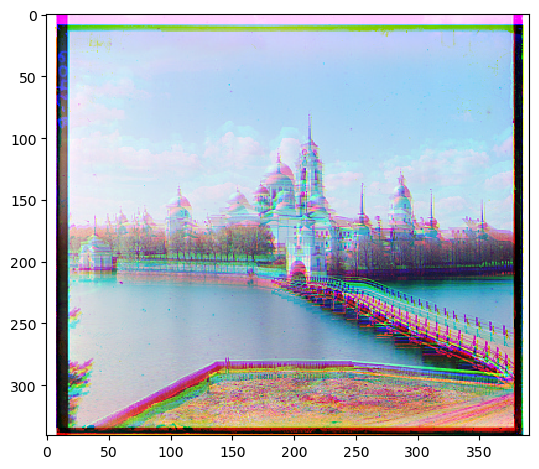

In [8]:
# Example usage
imname = 'monastery.jpg'
# imname = 'cathedral.jpg'
# imname = 'tobolsk.jpg'

# read in the image
im = skio.imread('../data/' + imname)
# im = skio.imread('/Users/filip/code/cs180/img/three_generations.tif')

# convert to double (might want to do this later on to save memory)    
im = img_as_float(im)

# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height:2 * height]
r = im[2 * height:3 * height]

# align the flattened images
ag = align(b, g)
ar = align(b, r)

# create a color image
im_out = np.dstack([ar, ag, b])

# display the image
skio.imshow(im_out)
skio.show()